## Final Capstone Project - Student Details


* Student name: Yessy Rayner
* Student pace: Part-time
* Mentor name: JP Hwang



# Analysis for BT Seoul Bike Rental Service in Seoul, South Korea

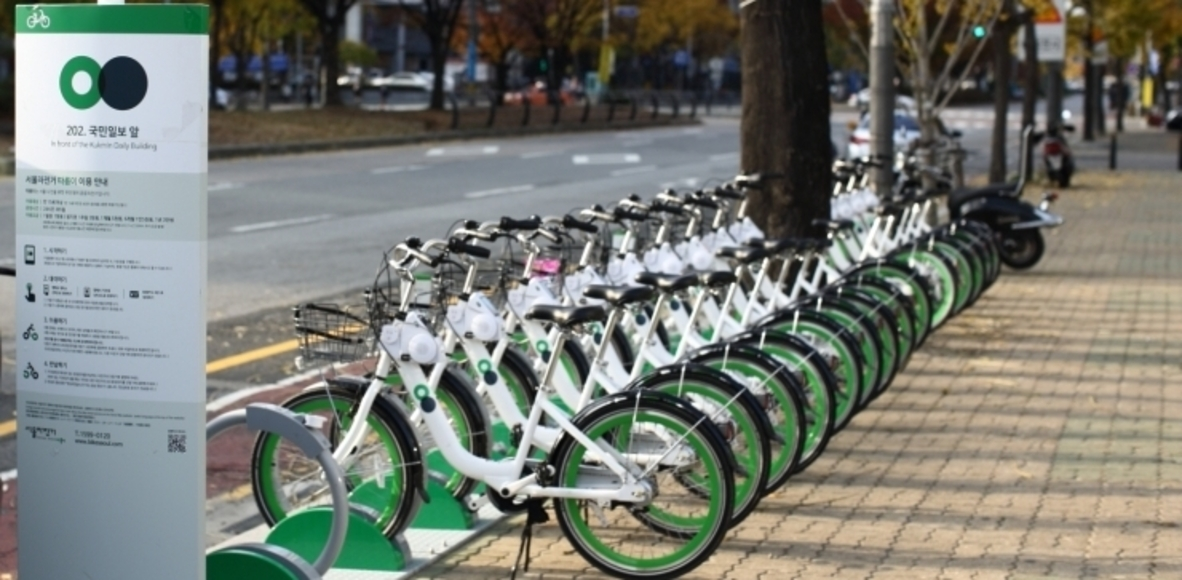

## Business Overview

Since COVID-19 pandemic, bike rentalbusinesses in Seoul are booming. This is an unexpected result for BT Seoul Bike Hire, so they would like some analysis on:

- How many extra staff members require during busy period. It is estimated by the management that 1 staff member required to service every 200 bikes/customers
- Quiet time of the day, so they can service their bikes with less disruption. They are currently close 1 day per month to service their bikes
- BT Seoul Bike Hire also would like to expand their business to other major metropolitan cities such as Busan and Incheon using the same business model and staffing method.


In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Dataset

The dataset contains rented bike count at each hour with the corresponding weather data and date information for the six months period (From March to October 2018). In total there are 7890 rented bike data counts with 10 features, which being grouped as follow for the testing and validation:

- Base variables: Temperature (C), Dewpoint (C), Solar radiation (MJ/m2) due to apparent linear relationship
- Continuous variables: Humidity (%), Windspeed (m/s), Visibility (10m), Snowfall (cm) and Rainfall (mm)
- Discrete variables: Date and Hour
- Categorical variables: Seasons and Holiday

In [2]:
#Now let's import the bike hire database for the 6 months period
bike_data = pd.read_csv('data2/SeoulBikeData.csv', encoding='unicode_escape')


In [3]:
bike_data.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

## Preprocessing / Data Cleaning

Here are some of the data preprocessing and cleaning methods being performed:
- Checked if all data are in correct data types
- Checked any missing data
- Added 2 additional categorial variables: Day_of_week (Monday to Sunday) and Shift(Early morning, Morning peak, Mid day, Evening peak) – This will help with predicting the staffing requirements 
- Drop ‘Functioning Day = No’ (Close down due to bike servicing day), removed the ‘No’ value as it skews the overall data.


In [4]:
# A quick look on data types and check if there are any missing value
bike_data.info()
#Excellent, looks like no missing data and majority of the data are in correct format
#I might convert the date to another format later for regression analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
#Convert Date into datetime dtype and adding an additional column to indentify the day (E.g. Mon-Sun)
bike_data['Date'] = pd.to_datetime(bike_data['Date'])
bike_data['Day_of_week'] = bike_data['Date'].dt.day_name()

In [6]:
bike_data = bike_data[['Day_of_week'] + [col for col in bike_data.columns if col != 'Day_of_week']]

In [7]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Day_of_week                8760 non-null   object        
 1   Date                       8760 non-null   datetime64[ns]
 2   Rented Bike Count          8760 non-null   int64         
 3   Hour                       8760 non-null   int64         
 4   Temperature(°C)            8760 non-null   float64       
 5   Humidity(%)                8760 non-null   int64         
 6   Wind speed (m/s)           8760 non-null   float64       
 7   Visibility (10m)           8760 non-null   int64         
 8   Dew point temperature(°C)  8760 non-null   float64       
 9   Solar Radiation (MJ/m2)    8760 non-null   float64       
 10  Rainfall(mm)               8760 non-null   float64       
 11  Snowfall (cm)              8760 non-null   float64       
 12  Season

In [8]:
bike_data.head()

Day_of_week       Date  Rented Bike Count  Hour  Temperature(°C)  \
0    Thursday 2017-01-12                254     0             -5.2   
1    Thursday 2017-01-12                204     1             -5.5   
2    Thursday 2017-01-12                173     2             -6.0   
3    Thursday 2017-01-12                107     3             -6.2   
4    Thursday 2017-01-12                 78     4             -6.0   

   Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0           37               2.2              2000                      -17.6   
1           38               0.8              2000                      -17.6   
2           39               1.0              2000                      -17.7   
3           40               0.9              2000                      -17.6   
4           36               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [9]:
#Let's have a closer look on Functioning Day
bike_data['Functioning Day'].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

In [10]:
bike_data.loc[bike_data['Functioning Day'] == 'No']

Day_of_week       Date  Rented Bike Count  Hour  Temperature(°C)  \
3144      Sunday 2018-11-04                  0     0             14.4   
3145      Sunday 2018-11-04                  0     1             13.6   
3146      Sunday 2018-11-04                  0     2             12.7   
3147      Sunday 2018-11-04                  0     3             11.6   
3148      Sunday 2018-11-04                  0     4             10.2   
...          ...        ...                ...   ...              ...   
8251     Tuesday 2018-09-11                  0    19             11.9   
8252     Tuesday 2018-09-11                  0    20             11.9   
8253     Tuesday 2018-09-11                  0    21             11.4   
8254     Tuesday 2018-09-11                  0    22             11.2   
8255     Tuesday 2018-09-11                  0    23             10.9   

      Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
3144           82               4.6              1041   
3145           81               3.6               886   
3146           80               3.9               885   
3147           81               3.1               687   
3148           83               3.5               554   
...           ...               ...               ...   
8251           71               2.7               589   
8252           72               2.5               526   
8253           74               1.9               498   
8254           75               1.7               478   
8255           76               1.2               456   

      Dew point temperature(°C)  Solar Radiation (MJ/m2)  Rainfall(mm)  \
3144                       11.3                      0.0           0.0   
3145                       10.3                      0.0           0.0   
3146                        9.3                      0.0           0.0   
3147                        8.4                      0.0           0.0   
3148                        7.4                      0.0           0.0   
...                         ...                      ...           ...   
8251                        6.7                      0.0           0.0   
8252                        7.0                      0.0           0.0   
8253                        6.9                      0.0           0.0   
8254                        6.9                      0.0           0.0   
8255                        6.8                      0.0           0.0   

      Snowfall (cm) Seasons     Holiday Functioning Day  
3144            0.0  Spring  No Holiday              No  
3145            0.0  Spring  No Holiday              No  
3146            0.0  Spring  No Holiday              No  
3147            0.0  Spring  No Holiday              No  
3148            0.0  Spring  No Holiday              No  
...             ...     ...         ...             ...  
8251            0.0  Autumn  No Holiday              No  
8252            0.0  Autumn  No Holiday              No  
8253            0.0  Autumn  No Holiday              No  
8254            0.0  Autumn  No Holiday              No  
8255            0.0  Autumn  No Holiday              No  

[295 rows x 15 columns]

Looking at the above result when the Functioning Day value is NO, no bikes were rented out and on the same day. Possibly due to bikes go on service or these were the time off for the staff members. Therefore, I am going to remove the "Functioning Day = No" data, as I am predicting number of bikes being rented out vs. other variables (especially weather). The NO data will skew my overall result, e.g. when temperature is nice and sunny but no bike were rented out, which doesn't make sense.


In [11]:
bike_data.drop(bike_data.index[bike_data['Functioning Day'] == 'No'], inplace=True)

In [12]:
bike_data.info()
#Some data has been deleted, approx. 295 less than initial data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Day_of_week                8465 non-null   object        
 1   Date                       8465 non-null   datetime64[ns]
 2   Rented Bike Count          8465 non-null   int64         
 3   Hour                       8465 non-null   int64         
 4   Temperature(°C)            8465 non-null   float64       
 5   Humidity(%)                8465 non-null   int64         
 6   Wind speed (m/s)           8465 non-null   float64       
 7   Visibility (10m)           8465 non-null   int64         
 8   Dew point temperature(°C)  8465 non-null   float64       
 9   Solar Radiation (MJ/m2)    8465 non-null   float64       
 10  Rainfall(mm)               8465 non-null   float64       
 11  Snowfall (cm)              8465 non-null   float64       
 12  Season

In [13]:
#I also would like to look closely at 'Hour' 
bike_data['Hour'].value_counts()

23    353
12    353
8     353
16    353
9     353
17    353
10    353
18    353
11    353
15    353
19    353
20    353
13    353
21    353
14    353
22    353
7     353
4     352
5     352
3     352
2     352
6     352
1     352
0     352
Name: Hour, dtype: int64

In [14]:
hour_var = ['Hour']

In [15]:
df_hour = bike_data[hour_var + ['Rented Bike Count']]
df_hour.head

<bound method NDFrame.head of       Hour  Rented Bike Count
0        0                254
1        1                204
2        2                173
3        3                107
4        4                 78
...    ...                ...
8755    19               1003
8756    20                764
8757    21                694
8758    22                712
8759    23                584

[8465 rows x 2 columns]>

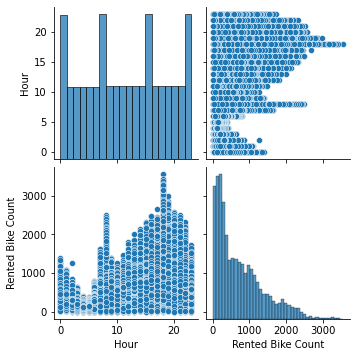

In [16]:
sns.pairplot(df_hour)

In [17]:
#Due to repetitive nature hour 0-23, I would like to add another column and group these up as categorical variable, 
# I will group them based on 4 lots of 6 hours shifts to help in analysing staffing requirements

def categorise (row):
    if row['Hour'] >= 0 and row['Hour'] <= 6:
        return 'Early morning'
    elif row['Hour'] >= 7 and row['Hour'] <= 12:
        return 'Morning peak'
    elif row['Hour'] > 13 and row['Hour'] <= 17:
        return 'Mid day'
    elif row['Hour'] > 18 and row['Hour'] <= 23:
        return 'Evening peak'
    return 'No'

In [18]:
bike_data['Shift'] = bike_data.apply(lambda row: categorise(row), axis=1)

In [19]:
bike_data.head()

Day_of_week       Date  Rented Bike Count  Hour  Temperature(°C)  \
0    Thursday 2017-01-12                254     0             -5.2   
1    Thursday 2017-01-12                204     1             -5.5   
2    Thursday 2017-01-12                173     2             -6.0   
3    Thursday 2017-01-12                107     3             -6.2   
4    Thursday 2017-01-12                 78     4             -6.0   

   Humidity(%)  Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0           37               2.2              2000                      -17.6   
1           38               0.8              2000                      -17.6   
2           39               1.0              2000                      -17.7   
3           40               0.9              2000                      -17.6   
4           36               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day          Shift  
0             Yes  Early morning  
1             Yes  Early morning  
2             Yes  Early morning  
3             Yes  Early morning  
4             Yes  Early morning

In [20]:
bike_data.describe(include=np.number)

Rented Bike Count         Hour  Temperature(°C)  Humidity(%)  \
count        8465.000000  8465.000000      8465.000000  8465.000000   
mean          729.156999    11.507029        12.771057    58.147194   
std           642.351166     6.920899        12.104375    20.484839   
min             2.000000     0.000000       -17.800000     0.000000   
25%           214.000000     6.000000         3.000000    42.000000   
50%           542.000000    12.000000        13.500000    57.000000   
75%          1084.000000    18.000000        22.700000    74.000000   
max          3556.000000    23.000000        39.400000    98.000000   

       Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
count       8465.000000       8465.000000                8465.000000   
mean           1.725883       1433.873479                   3.944997   
std            1.034281        609.051229                  13.242399   
min            0.000000         27.000000                 -30.600000   
25%            0.900000        935.000000                  -5.100000   
50%            1.500000       1690.000000                   4.700000   
75%            2.300000       2000.000000                  15.200000   
max            7.400000       2000.000000                  27.200000   

       Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  
count              8465.000000    8465.00000    8465.000000  
mean                  0.567868       0.14912       0.077685  
std                   0.868245       1.12554       0.444063  
min                   0.000000       0.00000       0.000000  
25%                   0.000000       0.00000       0.000000  
50%                   0.010000       0.00000       0.000000  
75%                   0.930000       0.00000       0.000000  
max                   3.520000      35.00000       8.800000

In [21]:
num_vars = bike_data.describe(include=np.number).columns.tolist()
num_vars = [c for c in num_vars if c != 'Rented Bike Count' ]
print(num_vars)

['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']


## Modelling

Using linear regression model to predict bike rental per hour or shift based on numerous features/variables.

Here are some of the methods being performed and tested using combinations of variables as well as other validation and transformation:
- Cross validation - where data being split into train and test data (75/25 split)
- Testing on different variables/models based on:
- Model 1: Base variables
- Model 2: Base + continuous variables
- Model 3: Base + continuous + discrete variables
- Model 4: Recursive Features Elimination 
- Model 5: ALL variables including categorial variables after being transformed using OneHotEncoder
- Popular Transformation methods performed in order to get the best fit, such as Logarithm, Min-Max Scaling, Standard Scaling, Polynomial-Interaction.


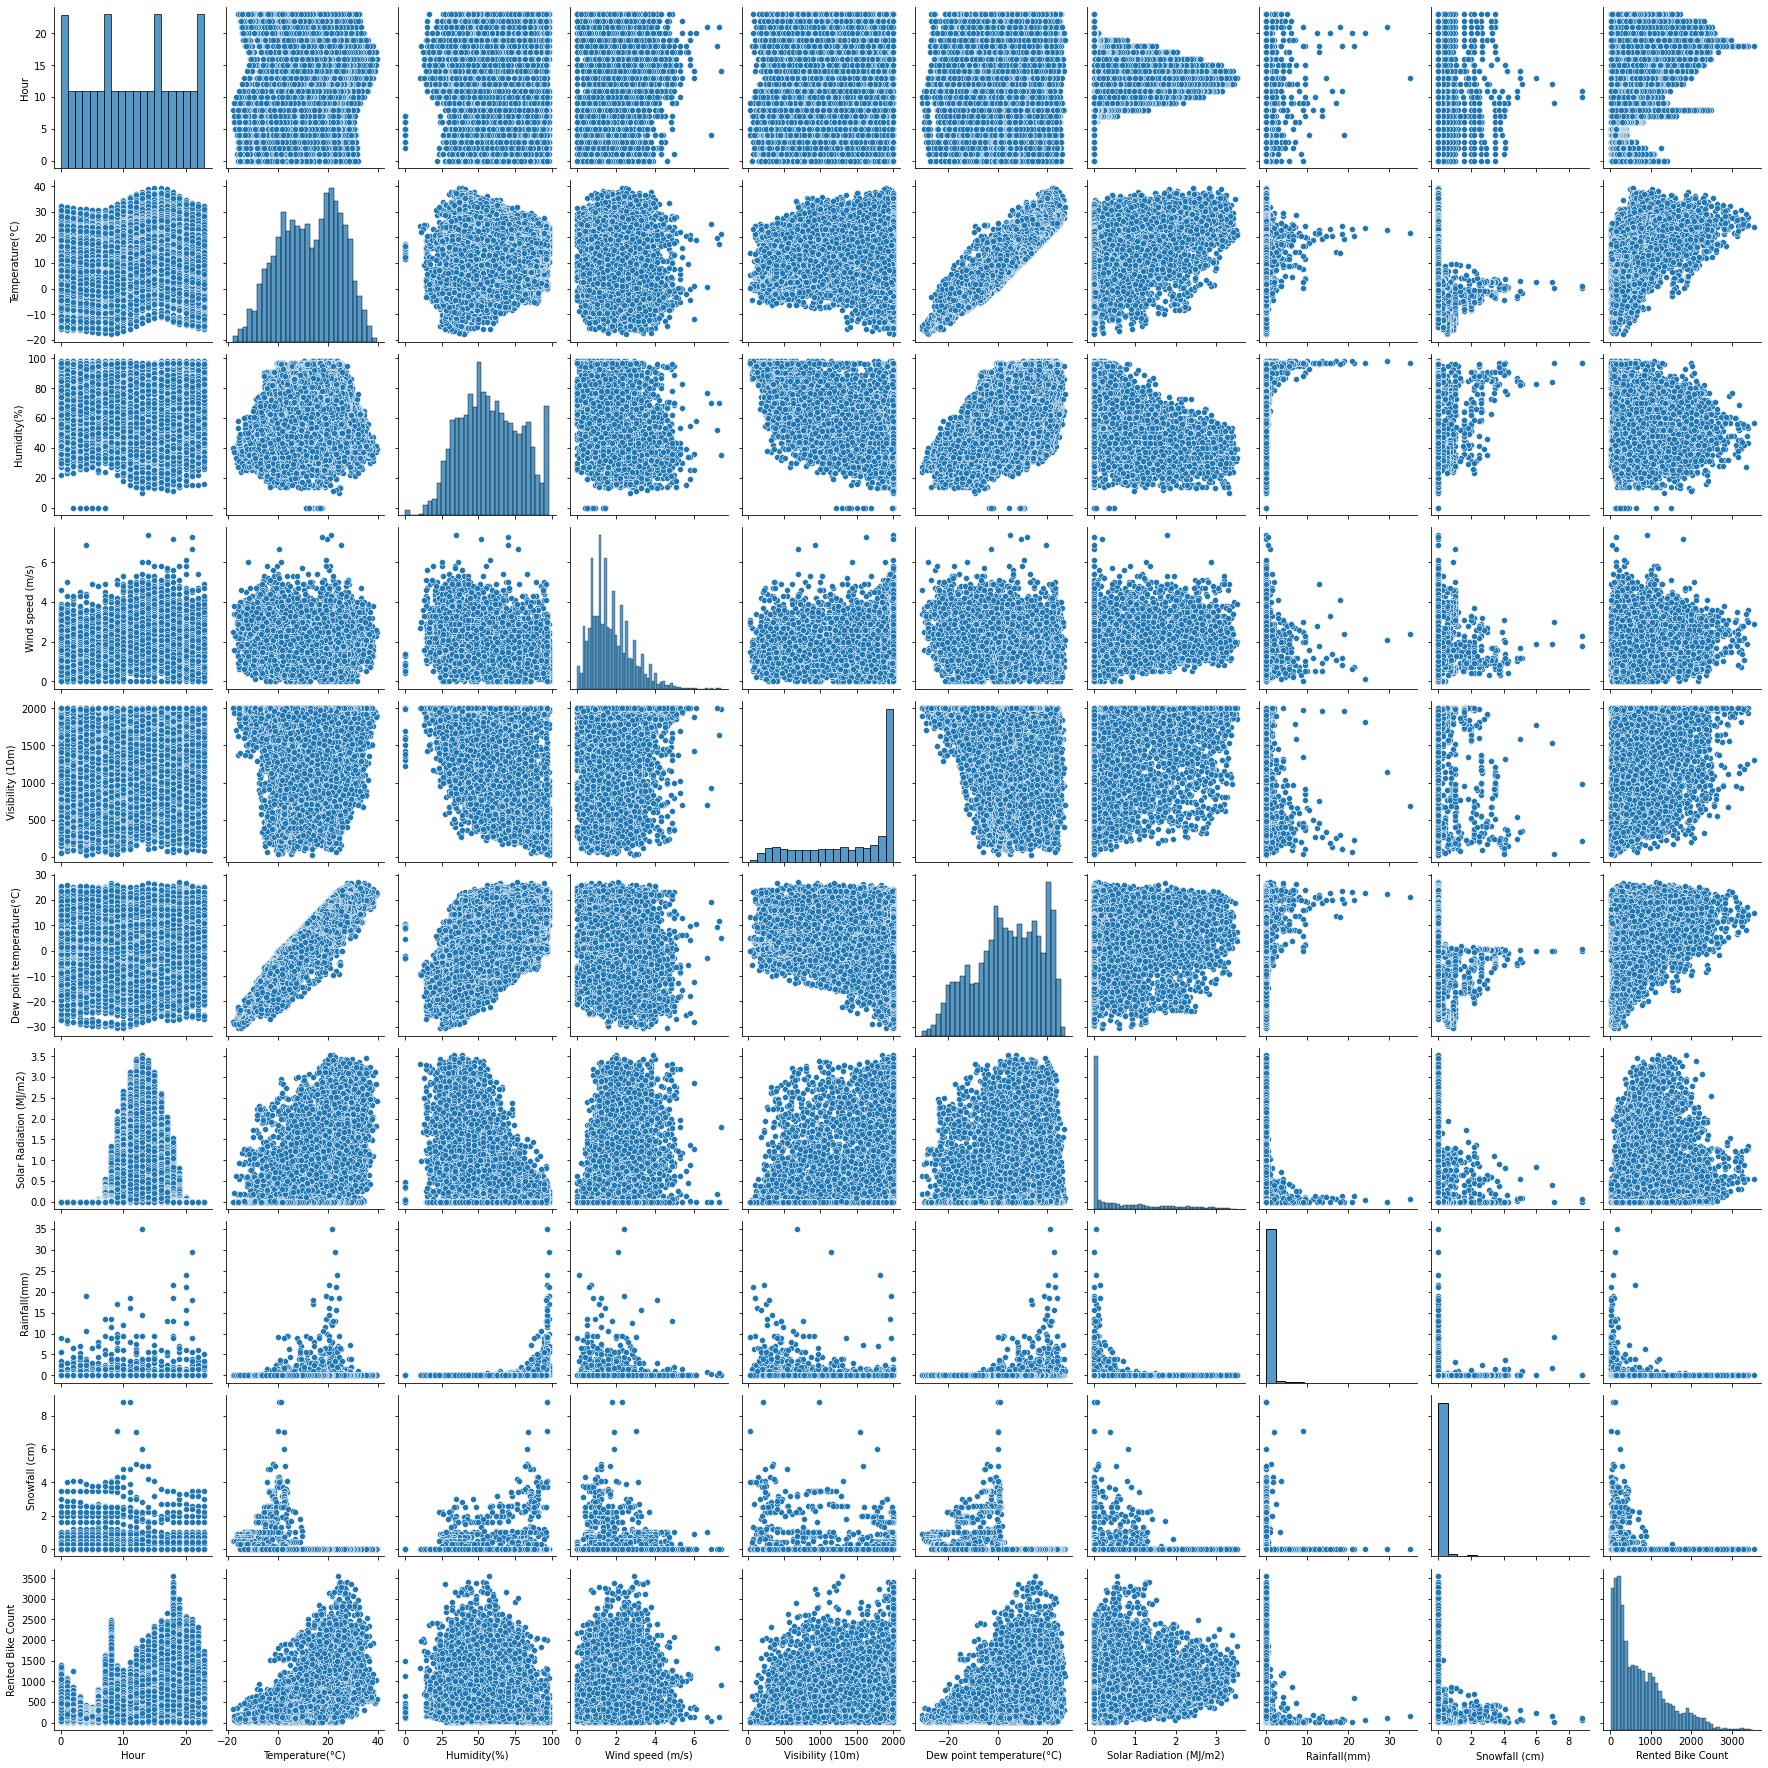

In [22]:
#Let's have a quick look to see if there are any relationship or inconsistency in the datas through pairplot

sns.pairplot(bike_data[num_vars + ['Rented Bike Count']])

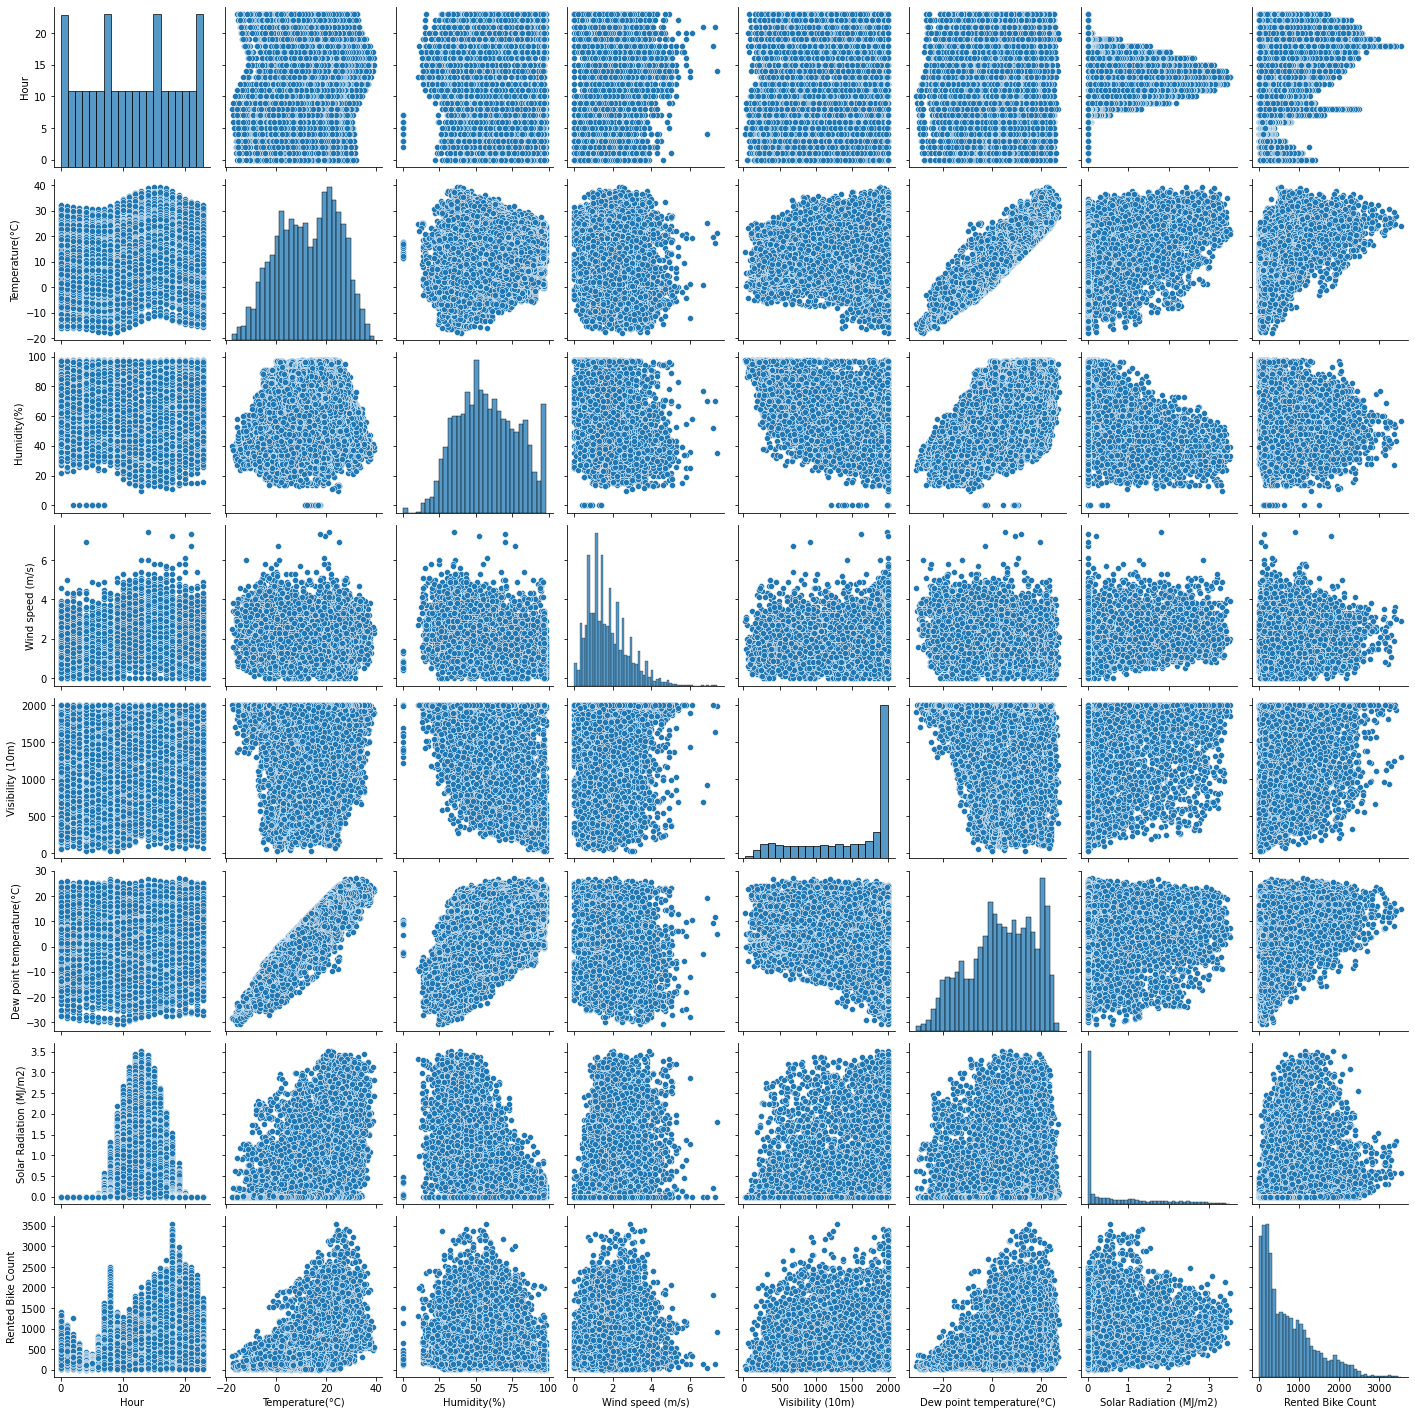

In [23]:
#Looking at the graphs above, temperature has strong linear regression relationship. 
#Wind speed, Dew point and Solar Radiation = somewhat weak linear relationship
#Zoom in to look at it closely
sns.pairplot(bike_data[num_vars [:7] + ['Rented Bike Count']])

In [24]:
#Checking the linear correlation and use the highest score to build base model
corr_df = bike_data[num_vars + ['Rented Bike Count']].corr()['Rented Bike Count'].reset_index()
corr_df[corr_df['Rented Bike Count'] > 0.4]
#Not many linear correlation

index  Rented Bike Count
0                       Hour           0.425256
1            Temperature(°C)           0.562740
5  Dew point temperature(°C)           0.400263
9          Rented Bike Count           1.000000

In [25]:
#Build base model using 3 apparent continuous variable as above, I won't be using hour, as it is part of discrete variable
#and I have separated the Hour into categorical called 'Shift'
base_vars = ['Temperature(°C)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)']

In [26]:
df_sm = bike_data[base_vars + ['Rented Bike Count']]
df_sm.head()

Temperature(°C)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0             -5.2                      -17.6                      0.0   
1             -5.5                      -17.6                      0.0   
2             -6.0                      -17.7                      0.0   
3             -6.2                      -17.6                      0.0   
4             -6.0                      -18.6                      0.0   

   Rented Bike Count  
0                254  
1                204  
2                173  
3                107  
4                 78

In [27]:
df_sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature(°C)            8465 non-null   float64
 1   Dew point temperature(°C)  8465 non-null   float64
 2   Solar Radiation (MJ/m2)    8465 non-null   float64
 3   Rented Bike Count          8465 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 330.7 KB


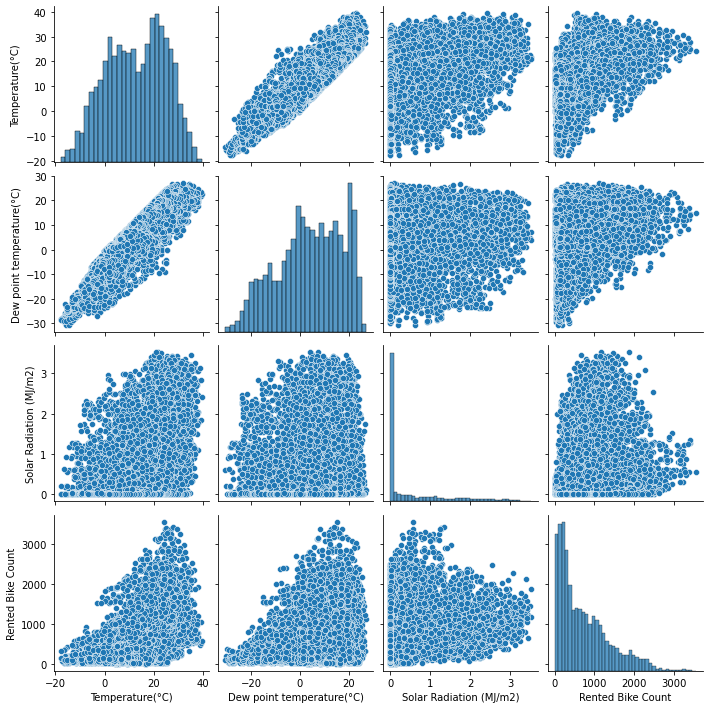

In [28]:
sns.pairplot(df_sm)

In [29]:
#Build a baseline model with just a few variables

X = df_sm.drop('Rented Bike Count', axis = 1)
y = df_sm['Rented Bike Count']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [31]:
X_train.head()

Temperature(°C)  Dew point temperature(°C)  Solar Radiation (MJ/m2)
1164              2.5                       -2.0                     0.00
4803             19.9                       14.0                     0.00
1450             -7.5                      -18.2                     0.55
3881             18.9                        6.6                     0.80
7447             14.3                       12.5                     0.03

In [32]:
y_train.head()

1164     267
4803     369
1450     170
3881    1863
7447     345
Name: Rented Bike Count, dtype: int64

In [33]:
#Check np array shape
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6348, 3) (2117, 3)
(6348,) (2117,)


In [34]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [35]:
linreg.fit(X_train, y_train)

LinearRegression()

In [36]:
#Produce Prediction
y_train_preds = linreg.predict(X_train)

In [37]:
y_val_preds = linreg.predict(X_val)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

r2_train = r2_score(y_train, y_train_preds)
r2_val = r2_score(y_val, y_val_preds)

mse_train = mean_squared_error(y_train, y_train_preds)
mse_val = mean_squared_error(y_val, y_val_preds)

print(f'R2 train: {r2_train} R2 validation: {r2_val}')
print(f'MSE train: {mse_train:.3e} R2 validation: {mse_val:.3e}')


R2 train: 0.4072502761454675 R2 validation: 0.413747771122949
MSE train: 2.480e+05 R2 validation: 2.315e+05


In [39]:
#Adjusted R2
def adj_r2_score(r2, n_samples, n_regressors):
    factor = (n_samples-1)/ (n_samples - n_regressors - 1)
    return 1 - ((1-r2) * factor)

In [40]:
adj_r2_train = adj_r2_score(r2_train, len(X_train), len(X_train.columns.tolist()))
adj_r2_val = adj_r2_score(r2_val, len(X_val), len(X_train.columns.tolist()))

print(f'Adj. R2 train: {adj_r2_train} Adj. R2 validation: {adj_r2_val}')
#Not much improvement

Adj. R2 train: 0.40696997205158914 Adj. R2 validation: 0.41291542058502617


Text(0, 0.5, 'Actual Amount')

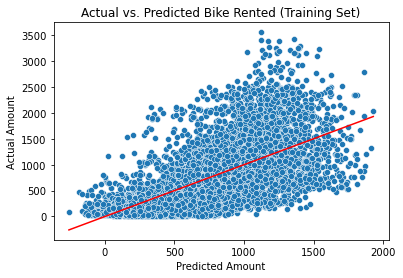

In [41]:
sns.scatterplot(x=y_train_preds, y=y_train)
sns.lineplot(x=y_train_preds, y=y_train_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Training Set)')
plt.xlabel('Predicted Amount')
plt.ylabel('Actual Amount')

Text(0, 0.5, 'Actual Amount')

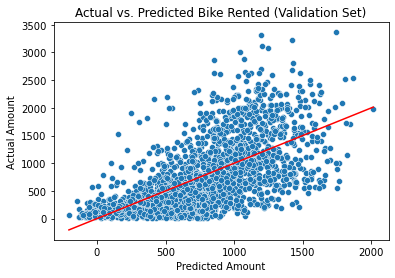

In [42]:
y_val_preds = linreg.predict(X_val)
sns.scatterplot(x=y_val_preds, y=y_val)
sns.lineplot(x=y_val_preds, y=y_val_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Validation Set)')
plt.xlabel('Predicted Amount')
plt.ylabel('Actual Amount')

<AxesSubplot:xlabel='Rented Bike Count', ylabel='Count'>

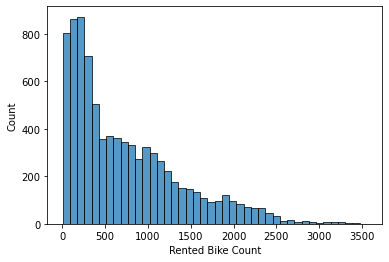

In [43]:
#Quicklook on the histogram to see if there's any pattern
sns.histplot(y)

<AxesSubplot:xlabel='Rented Bike Count', ylabel='Count'>

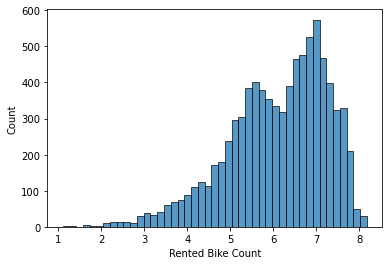

In [44]:
#Log transform y var for better understanding
y = np.log1p(y) 
sns.histplot(y)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

# Transform with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_preds = linreg.predict(X_train_scaled)
y_val_preds = linreg.predict(X_val_scaled)

Text(0, 0.5, 'Actual')

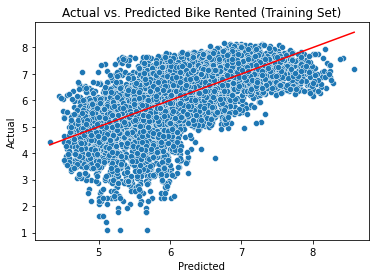

In [46]:
#Checking if the train set improved
sns.scatterplot(x=y_train_preds, y=y_train)
sns.lineplot(x=y_train_preds, y=y_train_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Training Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#Not much improvement

Text(0, 0.5, 'Actual')

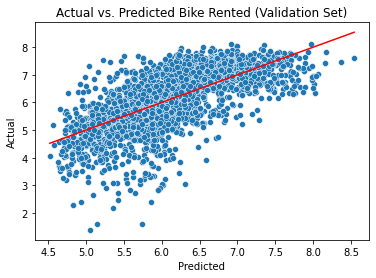

In [47]:
#Checking if the test/validation set improved
y_val_preds = linreg.predict(X_val_scaled)
sns.scatterplot(x=y_val_preds, y=y_val)
sns.lineplot(x=y_val_preds, y=y_val_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [48]:
#Cross Validation CV Test
from sklearn.model_selection import cross_validate
scores = cross_validate(linreg, X, y, cv=5, 
                       scoring=['r2', 'neg_mean_squared_error'],
                       return_train_score=True)
scores
#Slightly better score

{'fit_time': array([0.00400543, 0.00499558, 0.00200486, 0.        , 0.        ]),
 'score_time': array([0.00298381, 0.00300145, 0.00323606, 0.01563597, 0.01402545]),
 'test_r2': array([ 0.09804677,  0.32940238,  0.33829941, -0.17695755,  0.03223641]),
 'train_r2': array([0.34365605, 0.44032929, 0.44182516, 0.45607826, 0.48151641]),
 'test_neg_mean_squared_error': array([-0.5362322 , -0.83167657, -1.03253969, -0.83303124, -0.94743613]),
 'train_neg_mean_squared_error': array([-0.81497026, -0.73524303, -0.68330714, -0.76199679, -0.71335992])}

In [49]:
#CV average score
avg_scores = {k:np.mean(v) for k, v in scores.items()}
avg_scores

{'fit_time': 0.0022011756896972655,
 'score_time': 0.0077765464782714845,
 'test_r2': 0.12420548602144657,
 'train_r2': 0.4326810359057444,
 'test_neg_mean_squared_error': -0.8361831674589585,
 'train_neg_mean_squared_error': -0.7417754276881003}

In [50]:
#Create evaluation list for all of validation test

eval_list = list()
avg_scores['dataset'] = 'base'
avg_scores['n_features'] = len(X.columns)
eval_list.append(avg_scores)
pd.DataFrame(eval_list)

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   

   train_neg_mean_squared_error dataset  n_features  
0                     -0.741775    base           3

In [51]:
#Define the function as we will be using the above metrics over and over

def get_avg_cv_scores(X, y, regmodel, setname, scoring=None):
    if scoring is None:
        scoring = ['r2', 'neg_mean_squared_error']
    scores = cross_validate(regmodel, X, y, cv=5,
                           scoring=scoring,
                           return_train_score=True)
    avg_scores = {k:np.mean(v) for k, v in scores.items()}
    avg_scores['dataset'] = setname
    avg_scores['n_features'] = len(X.columns)
    return avg_scores

In [52]:
# Introduce new continuous features
# Then analyse to see which one to include and exclude

cont_vars = ['Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Rainfall(mm)', 'Snowfall (cm)']

In [53]:
df_cont = bike_data[cont_vars + ['Rented Bike Count']]
df_cont.head()

Humidity(%)  Wind speed (m/s)  Visibility (10m)  Rainfall(mm)  \
0           37               2.2              2000           0.0   
1           38               0.8              2000           0.0   
2           39               1.0              2000           0.0   
3           40               0.9              2000           0.0   
4           36               2.3              2000           0.0   

   Snowfall (cm)  Rented Bike Count  
0            0.0                254  
1            0.0                204  
2            0.0                173  
3            0.0                107  
4            0.0                 78

In [54]:
bike_data[cont_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Humidity(%)       8465 non-null   int64  
 1   Wind speed (m/s)  8465 non-null   float64
 2   Visibility (10m)  8465 non-null   int64  
 3   Rainfall(mm)      8465 non-null   float64
 4   Snowfall (cm)     8465 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 396.8 KB


In [55]:
bike_data[cont_vars].describe()

Humidity(%)  Wind speed (m/s)  Visibility (10m)  Rainfall(mm)  \
count  8465.000000       8465.000000       8465.000000    8465.00000   
mean     58.147194          1.725883       1433.873479       0.14912   
std      20.484839          1.034281        609.051229       1.12554   
min       0.000000          0.000000         27.000000       0.00000   
25%      42.000000          0.900000        935.000000       0.00000   
50%      57.000000          1.500000       1690.000000       0.00000   
75%      74.000000          2.300000       2000.000000       0.00000   
max      98.000000          7.400000       2000.000000      35.00000   

       Snowfall (cm)  
count    8465.000000  
mean        0.077685  
std         0.444063  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         8.800000

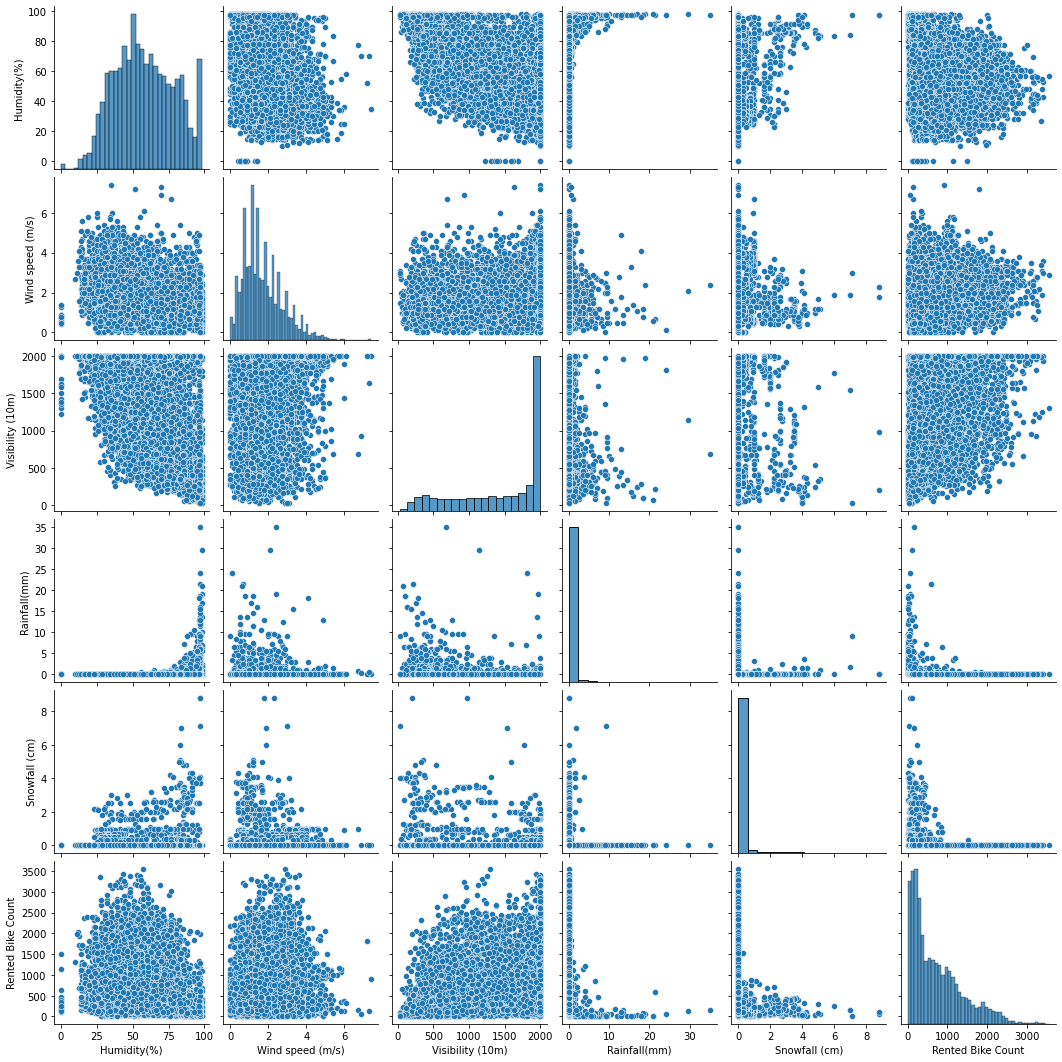

In [56]:
sns.pairplot(df_cont)

In [57]:
#Check for multicolinearity

bike_data[cont_vars].corr()[abs(bike_data[cont_vars].corr()) > 0.6]

#Absent of multicolinearity 

Humidity(%)  Wind speed (m/s)  Visibility (10m)  \
Humidity(%)               1.0               NaN               NaN   
Wind speed (m/s)          NaN               1.0               NaN   
Visibility (10m)          NaN               NaN               1.0   
Rainfall(mm)              NaN               NaN               NaN   
Snowfall (cm)             NaN               NaN               NaN   

                  Rainfall(mm)  Snowfall (cm)  
Humidity(%)                NaN            NaN  
Wind speed (m/s)           NaN            NaN  
Visibility (10m)           NaN            NaN  
Rainfall(mm)               1.0            NaN  
Snowfall (cm)              NaN            1.0

In [58]:
#Lets add base+cont_vars to our linreg test
X = bike_data[base_vars + cont_vars]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

# Transform with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_preds = linreg.predict(X_train_scaled)
y_val_preds = linreg.predict(X_val_scaled)

In [59]:
#Check np array shape
print(X_train_scaled.shape, X_val_scaled.shape)
print(y_train.shape, y_val.shape)

(6348, 8) (2117, 8)
(6348,) (2117,)


In [60]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'w/cont. feats')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#Slight improvement for R2 from 0.432 to 0.508

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   

   train_neg_mean_squared_error        dataset  n_features  
0                     -0.741775           base           3  
1                     -0.642021  w/cont. feats           8

In [61]:
#Running a quick info, so I can grab the name of features on the next step
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Day_of_week                8465 non-null   object        
 1   Date                       8465 non-null   datetime64[ns]
 2   Rented Bike Count          8465 non-null   int64         
 3   Hour                       8465 non-null   int64         
 4   Temperature(°C)            8465 non-null   float64       
 5   Humidity(%)                8465 non-null   int64         
 6   Wind speed (m/s)           8465 non-null   float64       
 7   Visibility (10m)           8465 non-null   int64         
 8   Dew point temperature(°C)  8465 non-null   float64       
 9   Solar Radiation (MJ/m2)    8465 non-null   float64       
 10  Rainfall(mm)               8465 non-null   float64       
 11  Snowfall (cm)              8465 non-null   float64       
 12  Season

In [62]:
#I am going to change the dtype of Date to ordinal, as the current format is not suitable for linear regression
import datetime as dt
bike_data['Date'] = pd.to_datetime(bike_data['Date'])
bike_data['Date']=bike_data['Date'].map(dt.datetime.toordinal)

In [63]:
# Now I am creating discrete variables

disc_vars = ['Hour', 'Date']
bike_data[disc_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Hour    8465 non-null   int64
 1   Date    8465 non-null   int64
dtypes: int64(2)
memory usage: 198.4 KB


In [64]:
bike_data[disc_vars].describe()

Hour           Date
count  8465.000000    8465.000000
mean     11.507029  736843.982398
std       6.920899     122.987869
min       0.000000  736341.000000
25%       6.000000  736755.000000
50%      12.000000  736848.000000
75%      18.000000  736940.000000
max      23.000000  737039.000000

In [65]:
df_disc = bike_data[disc_vars + ['Rented Bike Count']]
df_disc.head()

Hour    Date  Rented Bike Count
0     0  736341                254
1     1  736341                204
2     2  736341                173
3     3  736341                107
4     4  736341                 78

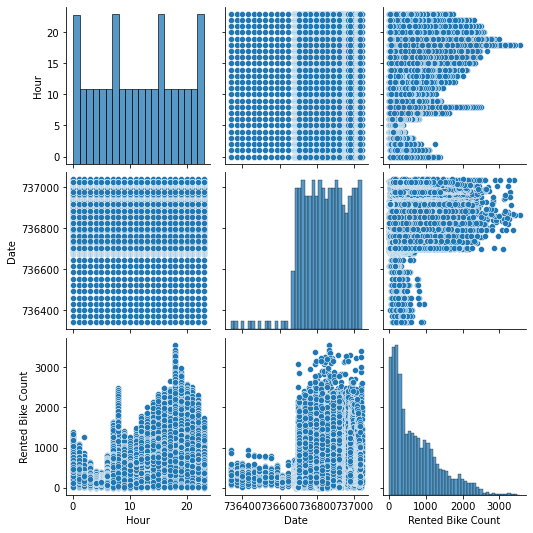

In [66]:
sns.pairplot(df_disc)
#There's some sort of pattern with the hours, where bike count increased during the morning & afternoon peak hours

In [67]:
#Next I will try combining base + disc + cont vars
X = bike_data[base_vars + cont_vars + disc_vars]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

# Transform with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_preds = linreg.predict(X_train_scaled)
y_val_preds = linreg.predict(X_val_scaled)

In [68]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'base+cont+disc. feats')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#R2 score just slightly better from 0.508 to 0.574

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10

In [69]:

X = bike_data[base_vars + disc_vars + cont_vars]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True,random_state=42)

In [70]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6348, 10) (2117, 10)
(6348,) (2117,)


In [71]:
#Next let's try RFE Recursive Feature Elimination with 6 features
from sklearn.feature_selection import RFE

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
n_feats = 6
selector = RFE(linreg, n_features_to_select=n_feats, step=1)
selector = selector.fit(X_train, y_train)


In [72]:
selector.ranking_

array([2, 1, 4, 1, 3, 1, 1, 5, 1, 1])

In [73]:
selector.support_

array([False,  True, False,  True, False,  True,  True, False,  True,
        True])

In [74]:
top_feats = X.columns[selector.support_]
top_feats

Index(['Dew point temperature(°C)', 'Hour', 'Humidity(%)', 'Wind speed (m/s)',
       'Rainfall(mm)', 'Snowfall (cm)'],
      dtype='object')

In [75]:
X = bike_data[cont_vars + base_vars + disc_vars]
X = X[top_feats]
X.head()

Dew point temperature(°C)  Hour  Humidity(%)  Wind speed (m/s)  \
0                      -17.6     0           37               2.2   
1                      -17.6     1           38               0.8   
2                      -17.7     2           39               1.0   
3                      -17.6     3           40               0.9   
4                      -18.6     4           36               2.3   

   Rainfall(mm)  Snowfall (cm)  
0           0.0            0.0  
1           0.0            0.0  
2           0.0            0.0  
3           0.0            0.0  
4           0.0            0.0

In [76]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'RFE6')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#slightly worse from 0.574 to 0.564

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6

In [77]:
#Test RFE to see how many features will produce the best scores

X = bike_data[cont_vars + base_vars + disc_vars]

train_r2_scores = list()
train_adj_r2_scores = list()
train_mse_values = list()

test_r2_scores = list()
test_adj_r2_scores = list()
test_mse_values = list()

n_feat_values = list()

for n_feats in range(3, len(X.columns)):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)
    selector = RFE(linreg, n_features_to_select=n_feats, step=1)
    selector = selector.fit(X_train, y_train)
    
    top_feats = X.columns[selector.support_]
    
    X_sm = X[top_feats]
    X_train, X_val, y_train, y_val = train_test_split(X_sm, y, test_size=0.25, shuffle=True, random_state=1)
    
    sm_linreg = LinearRegression()
    sm_linreg.fit(X_train, y_train)
    
    y_train_preds = sm_linreg.predict(X_train)
    y_val_preds = sm_linreg.predict(X_val)
    
    train_r2_scores.append(r2_score(y_train, y_train_preds))
    train_mse_values.append(mean_squared_error(y_train, y_train_preds))
    
    test_r2_scores.append(r2_score(y_val, y_val_preds))
    test_mse_values.append(mean_squared_error(y_val, y_val_preds))
    
    n_feat_values.append(n_feats)

Text(0.5, 1.0, 'R2 scores')

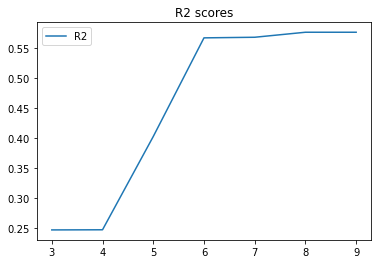

In [78]:
sns.lineplot(x=n_feat_values, y=train_r2_scores, label='R2')
plt.title('R2 scores')
#Looks like 8 features would produce the best score, lets put it to the test next

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)
n_feats = 8
selector = RFE(linreg, n_features_to_select=n_feats, step=1)
selector = selector.fit(X_train, y_train)


In [80]:
selector.ranking_

array([1, 1, 3, 1, 1, 1, 1, 2, 1, 1])

In [81]:
selector.support_

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True])

In [82]:
top_feats = X.columns[selector.support_]
top_feats

Index(['Humidity(%)', 'Wind speed (m/s)', 'Rainfall(mm)', 'Snowfall (cm)',
       'Temperature(°C)', 'Dew point temperature(°C)', 'Hour', 'Date'],
      dtype='object')

In [83]:
X = bike_data[cont_vars + base_vars + disc_vars]
X = X[top_feats]

linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'RFE8')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#very slight improvement from 0.564 to 0.573

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   
4  0.008250    0.006198  0.250754  0.573521                    -0.695773   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6  
4                     -0.557856                   RFE8           8

In [84]:
# Now lets add categorical features

cat_vars = bike_data.describe(include=object).columns.tolist()
bike_data[cat_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Day_of_week      8465 non-null   object
 1   Seasons          8465 non-null   object
 2   Holiday          8465 non-null   object
 3   Functioning Day  8465 non-null   object
 4   Shift            8465 non-null   object
dtypes: object(5)
memory usage: 396.8+ KB


In [85]:
#Next I will convert the object to numerical label, as object won't work on the next step of linreg using OHE
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
bike_data['Day_of_week_cat'] = labelencoder.fit_transform(bike_data['Day_of_week'])
bike_data['Seasons_cat'] = labelencoder.fit_transform(bike_data['Seasons'])
bike_data['Holiday_cat'] = labelencoder.fit_transform(bike_data['Holiday'])
bike_data['Shift_cat'] = labelencoder.fit_transform(bike_data['Shift'])


In [86]:
bike_data.head()

Day_of_week    Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0    Thursday  736341                254     0             -5.2           37   
1    Thursday  736341                204     1             -5.5           38   
2    Thursday  736341                173     2             -6.0           39   
3    Thursday  736341                107     3             -6.2           40   
4    Thursday  736341                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day          Shift  Day_of_week_cat  Seasons_cat  Holiday_cat  \
0             Yes  Early morning                4            3            1   
1             Yes  Early morning                4            3            1   
2             Yes  Early morning                4            3            1   
3             Yes  Early morning                4            3            1   
4             Yes  Early morning                4            3            1   

   Shift_cat  
0          0  
1          0  
2          0  
3          0  
4          0

In [87]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Day_of_week                8465 non-null   object 
 1   Date                       8465 non-null   int64  
 2   Rented Bike Count          8465 non-null   int64  
 3   Hour                       8465 non-null   int64  
 4   Temperature(°C)            8465 non-null   float64
 5   Humidity(%)                8465 non-null   int64  
 6   Wind speed (m/s)           8465 non-null   float64
 7   Visibility (10m)           8465 non-null   int64  
 8   Dew point temperature(°C)  8465 non-null   float64
 9   Solar Radiation (MJ/m2)    8465 non-null   float64
 10  Rainfall(mm)               8465 non-null   float64
 11  Snowfall (cm)              8465 non-null   float64
 12  Seasons                    8465 non-null   object 
 13  Holiday                    8465 non-null   objec

In [88]:
cat_vars = bike_data.describe(include='int32').columns.tolist()
bike_data[cat_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Day_of_week_cat  8465 non-null   int32
 1   Seasons_cat      8465 non-null   int32
 2   Holiday_cat      8465 non-null   int32
 3   Shift_cat        8465 non-null   int32
dtypes: int32(4)
memory usage: 198.4 KB


In [89]:
#I have cleaned the data at the very beginning, but will double-check if there's any missing values
bike_data[cat_vars].isnull().sum()
#No missing value

Day_of_week_cat    0
Seasons_cat        0
Holiday_cat        0
Shift_cat          0
dtype: int64

In [90]:
bike_data[cat_vars].describe()

Day_of_week_cat  Seasons_cat  Holiday_cat    Shift_cat
count      8465.000000  8465.000000  8465.000000  8465.000000
mean          3.039693     1.542351     0.951802     1.626344
std           1.994874     1.102876     0.214198     1.348051
min           0.000000     0.000000     0.000000     0.000000
25%           1.000000     1.000000     1.000000     0.000000
50%           3.000000     2.000000     1.000000     2.000000
75%           5.000000     3.000000     1.000000     3.000000
max           6.000000     3.000000     1.000000     4.000000

In [91]:
#Now I am using OneHotEncoder to help transform categorical datas/features

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(bike_data[cat_vars])
ohe_cols = enc.transform(bike_data[cat_vars])
ohe_cols.toarray().shape

(8465, 18)

In [92]:
ohe_df = pd.DataFrame(ohe_cols.toarray(), columns=enc.get_feature_names_out(cat_vars), index=bike_data.index)
ohe_df.head()

Day_of_week_cat_0  Day_of_week_cat_1  Day_of_week_cat_2  Day_of_week_cat_3  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   Day_of_week_cat_4  Day_of_week_cat_5  Day_of_week_cat_6  Seasons_cat_0  \
0                1.0                0.0                0.0            0.0   
1                1.0                0.0                0.0            0.0   
2                1.0                0.0                0.0            0.0   
3                1.0                0.0                0.0            0.0   
4                1.0                0.0                0.0            0.0   

   Seasons_cat_1  Seasons_cat_2  Seasons_cat_3  Holiday_cat_0  Holiday_cat_1  \
0            0.0            0.0            1.0            0.0            1.0   
1            0.0            0.0            1.0            0.0            1.0   
2            0.0            0.0            1.0            0.0            1.0   
3            0.0            0.0            1.0            0.0            1.0   
4            0.0            0.0            1.0            0.0            1.0   

   Shift_cat_0  Shift_cat_1  Shift_cat_2  Shift_cat_3  Shift_cat_4  
0          1.0          0.0          0.0          0.0          0.0  
1          1.0          0.0          0.0          0.0          0.0  
2          1.0          0.0          0.0          0.0          0.0  
3          1.0          0.0          0.0          0.0          0.0  
4          1.0          0.0          0.0          0.0          0.0

In [93]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Day_of_week_cat_0  8465 non-null   float64
 1   Day_of_week_cat_1  8465 non-null   float64
 2   Day_of_week_cat_2  8465 non-null   float64
 3   Day_of_week_cat_3  8465 non-null   float64
 4   Day_of_week_cat_4  8465 non-null   float64
 5   Day_of_week_cat_5  8465 non-null   float64
 6   Day_of_week_cat_6  8465 non-null   float64
 7   Seasons_cat_0      8465 non-null   float64
 8   Seasons_cat_1      8465 non-null   float64
 9   Seasons_cat_2      8465 non-null   float64
 10  Seasons_cat_3      8465 non-null   float64
 11  Holiday_cat_0      8465 non-null   float64
 12  Holiday_cat_1      8465 non-null   float64
 13  Shift_cat_0        8465 non-null   float64
 14  Shift_cat_1        8465 non-null   float64
 15  Shift_cat_2        8465 non-null   float64
 16  Shift_cat_3        8465 

In [94]:
X = bike_data[base_vars + cont_vars + disc_vars].join(ohe_df)
X.head()

Temperature(°C)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0             -5.2                      -17.6                      0.0   
1             -5.5                      -17.6                      0.0   
2             -6.0                      -17.7                      0.0   
3             -6.2                      -17.6                      0.0   
4             -6.0                      -18.6                      0.0   

   Humidity(%)  Wind speed (m/s)  Visibility (10m)  Rainfall(mm)  \
0           37               2.2              2000           0.0   
1           38               0.8              2000           0.0   
2           39               1.0              2000           0.0   
3           40               0.9              2000           0.0   
4           36               2.3              2000           0.0   

   Snowfall (cm)  Hour    Date  ...  Seasons_cat_1  Seasons_cat_2  \
0            0.0     0  736341  ...            0.0            0.0   
1            0.0     1  736341  ...            0.0            0.0   
2            0.0     2  736341  ...            0.0            0.0   
3            0.0     3  736341  ...            0.0            0.0   
4            0.0     4  736341  ...            0.0            0.0   

   Seasons_cat_3  Holiday_cat_0  Holiday_cat_1  Shift_cat_0  Shift_cat_1  \
0            1.0            0.0            1.0          1.0          0.0   
1            1.0            0.0            1.0          1.0          0.0   
2            1.0            0.0            1.0          1.0          0.0   
3            1.0            0.0            1.0          1.0          0.0   
4            1.0            0.0            1.0          1.0          0.0   

   Shift_cat_2  Shift_cat_3  Shift_cat_4  
0          0.0          0.0          0.0  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0          0.0  
4          0.0          0.0          0.0  

[5 rows x 28 columns]

In [95]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature(°C)            8465 non-null   float64
 1   Dew point temperature(°C)  8465 non-null   float64
 2   Solar Radiation (MJ/m2)    8465 non-null   float64
 3   Humidity(%)                8465 non-null   int64  
 4   Wind speed (m/s)           8465 non-null   float64
 5   Visibility (10m)           8465 non-null   int64  
 6   Rainfall(mm)               8465 non-null   float64
 7   Snowfall (cm)              8465 non-null   float64
 8   Hour                       8465 non-null   int64  
 9   Date                       8465 non-null   int64  
 10  Day_of_week_cat_0          8465 non-null   float64
 11  Day_of_week_cat_1          8465 non-null   float64
 12  Day_of_week_cat_2          8465 non-null   float64
 13  Day_of_week_cat_3          8465 non-null   float

In [96]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'all variables')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#Pretty good improvement from 0.573 to 0.661

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   
4  0.008250    0.006198  0.250754  0.573521                    -0.695773   
5  0.024422    0.006237  0.418418  0.661940                    -0.562520   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6  
4                     -0.557856                   RFE8           8  
5                     -0.442799          all variables          28

In [97]:
#Lets do another check on our model
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)
linreg.fit(X_train, y_train)

LinearRegression()

Text(0, 0.5, 'Actual')

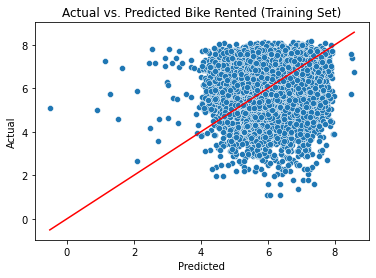

In [98]:
#Train set
sns.scatterplot(x=y_train_preds, y=y_train)
sns.lineplot(x=y_train_preds, y=y_train_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Training Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(0, 0.5, 'Actual')

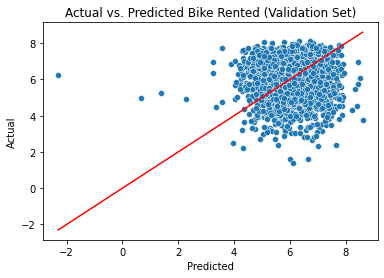

In [99]:
#Test set
sns.scatterplot(x=y_val_preds, y=y_val)
sns.lineplot(x=y_val_preds, y=y_val_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [100]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

# Transform with MinMax
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_train_preds = linreg.predict(X_train_scaled)
y_val_preds = linreg.predict(X_val_scaled)

In [101]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'all vars scaled')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#No improvement caused I already used StandardScaler earlier

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   
4  0.008250    0.006198  0.250754  0.573521                    -0.695773   
5  0.024422    0.006237  0.418418  0.661940                    -0.562520   
6  0.017623    0.009526  0.418418  0.661940                    -0.562520   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6  
4                     -0.557856                   RFE8           8  
5                     -0.442799          all variables          28  
6                     -0.442799        all vars scaled          28

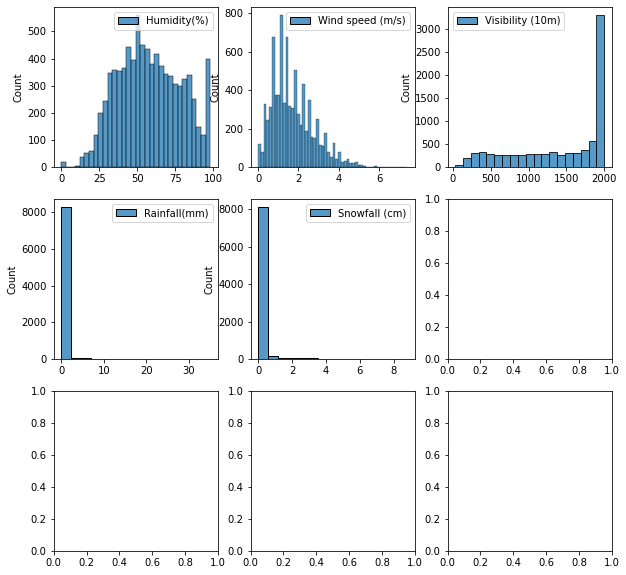

In [102]:
#Now we will transform our input variables, also a quick check on continuous variable to see if there are any 
#similar pattern that we can get rid off in order to produce better result

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(len(cont_vars)):
    sns.histplot(bike_data[[cont_vars[i]]], ax=ax[i // 3, i % 3])
    
#Results are varied, so leaving the cont vars as it is

In [103]:
#Next I am going to log transform all of the cont vars due to some skewness in the graph above, as we also did a log on y, 
#so to speak to keep the score/value consistents, not using temperature as log doesn't work on negative value

X = np.log1p(bike_data[cont_vars]).join(bike_data[base_vars + disc_vars]).join(ohe_df)
X.head()

Humidity(%)  Wind speed (m/s)  Visibility (10m)  Rainfall(mm)  \
0     3.637586          1.163151          7.601402           0.0   
1     3.663562          0.587787          7.601402           0.0   
2     3.688879          0.693147          7.601402           0.0   
3     3.713572          0.641854          7.601402           0.0   
4     3.610918          1.193922          7.601402           0.0   

   Snowfall (cm)  Temperature(°C)  Dew point temperature(°C)  \
0            0.0             -5.2                      -17.6   
1            0.0             -5.5                      -17.6   
2            0.0             -6.0                      -17.7   
3            0.0             -6.2                      -17.6   
4            0.0             -6.0                      -18.6   

   Solar Radiation (MJ/m2)  Hour    Date  ...  Seasons_cat_1  Seasons_cat_2  \
0                      0.0     0  736341  ...            0.0            0.0   
1                      0.0     1  736341  ...            0.0            0.0   
2                      0.0     2  736341  ...            0.0            0.0   
3                      0.0     3  736341  ...            0.0            0.0   
4                      0.0     4  736341  ...            0.0            0.0   

   Seasons_cat_3  Holiday_cat_0  Holiday_cat_1  Shift_cat_0  Shift_cat_1  \
0            1.0            0.0            1.0          1.0          0.0   
1            1.0            0.0            1.0          1.0          0.0   
2            1.0            0.0            1.0          1.0          0.0   
3            1.0            0.0            1.0          1.0          0.0   
4            1.0            0.0            1.0          1.0          0.0   

   Shift_cat_2  Shift_cat_3  Shift_cat_4  
0          0.0          0.0          0.0  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0          0.0  
4          0.0          0.0          0.0  

[5 rows x 28 columns]

In [104]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X.astype(float), y.astype(float), linreg, 'all vars log')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#Pretty good R2 improvement from 0.661 to 0.707

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   
4  0.008250    0.006198  0.250754  0.573521                    -0.695773   
5  0.024422    0.006237  0.418418  0.661940                    -0.562520   
6  0.017623    0.009526  0.418418  0.661940                    -0.562520   
7  0.015625    0.003124  0.424244  0.707258                    -0.566891   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6  
4                     -0.557856                   RFE8           8  
5                     -0.442799          all variables          28  
6                     -0.442799        all vars scaled          28  
7                     -0.383100           all vars log          28

In [105]:
#score improved to 0.707, not perfect so will try polynomial-interaction regression
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias = False, order='C')

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.fit_transform(X_val)

pol_reg = LinearRegression().fit(X_train_poly, y_train)

y_train_preds = pol_reg.predict(X_train_poly)
y_val_preds = pol_reg.predict(X_val_poly)

In [106]:
linreg = LinearRegression()
avg_scores = get_avg_cv_scores(X, y, linreg, 'all vars poly')
eval_list.append(avg_scores)
pd.DataFrame(eval_list)
#No improvement, perhaps my data doesn't suit curve/polynomial regression model

fit_time  score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0  0.002201    0.007777  0.124205  0.432681                    -0.836183   
1  0.006323    0.004923  0.121082  0.508691                    -0.801977   
2  0.008448    0.000207  0.237863  0.574026                    -0.705235   
3  0.012498    0.003125  0.238775  0.564145                    -0.697286   
4  0.008250    0.006198  0.250754  0.573521                    -0.695773   
5  0.024422    0.006237  0.418418  0.661940                    -0.562520   
6  0.017623    0.009526  0.418418  0.661940                    -0.562520   
7  0.015625    0.003124  0.424244  0.707258                    -0.566891   
8  0.010464    0.000000  0.424244  0.707258                    -0.566891   

   train_neg_mean_squared_error                dataset  n_features  
0                     -0.741775                   base           3  
1                     -0.642021          w/cont. feats           8  
2                     -0.557168  base+cont+disc. feats          10  
3                     -0.569875                   RFE6           6  
4                     -0.557856                   RFE8           8  
5                     -0.442799          all variables          28  
6                     -0.442799        all vars scaled          28  
7                     -0.383100           all vars log          28  
8                     -0.383100          all vars poly          28

Text(0, 0.5, 'Actual')

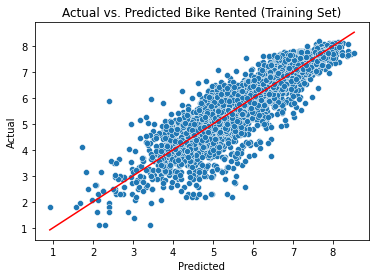

In [107]:
#Lets do another check on our model
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)
linreg.fit(X_train, y_train)

#Train set
sns.scatterplot(x=y_train_preds, y=y_train)
sns.lineplot(x=y_train_preds, y=y_train_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Training Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#Pretty good linear relationship

Text(0, 0.5, 'Actual')

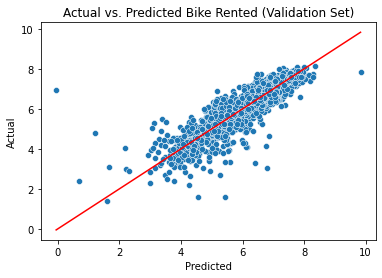

In [108]:
#Test set
sns.scatterplot(x=y_val_preds, y=y_val)
sns.lineplot(x=y_val_preds, y=y_val_preds, color='red')
plt.title('Actual vs. Predicted Bike Rented (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [109]:
#Next we will run the linear model in 'Price' as the target variable in statsmodel 
#to see if the results are similar to our previous R2 & MSE analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented Bike Count   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     842.9
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:30:32   Log-Likelihood:                -8045.6
No. Observations:                8465   AIC:                         1.614e+04
Df Residuals:                    8440   BIC:                         1.632e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       129.9118     26.801      4.847      0.000      77.376     182.448
Humidity(%)                   0.0718      0.038      1.904      0.057      -0.002       0.146
Wind speed (m/s)             -0.0402      0.021     -1.879      0.060      -0.082       0.002
Visibility (10m)              0.0856      0.013      6.391      0.000       0.059       0.112
Rainfall(mm)                 -1.5121      0.026    -57.957      0.000      -1.563      -1.461
Snowfall (cm)                -0.1293      0.036     -3.636      0.000      -0.199      -0.060
Temperature(°C)               0.0846      0.004     24.139      0.000       0.078       0.092
Dew point temperature(°C)    -0.0460      0.003    -13.601      0.000      -0.053      -0.039
Solar Radiation (MJ/m2)      -0.1658      0.013    -12.440      0.000      -0.192      -0.140
Hour                         -0.0573      0.004    -14.664      0.000      -0.065      -0.050
Date                         -0.0004   7.61e-05     -4.755      0.000      -0.001      -0.000
Day_of_week_cat_0            18.5929      3.828      4.857      0.000      11.088      26.098
Day_of_week_cat_1            18.5769      3.830      4.851      0.000      11.070      26.084
Day_of_week_cat_2            18.5461      3.829      4.844      0.000      11.040      26.052
Day_of_week_cat_3            18.4391      3.828      4.816      0.000      10.935      25.944
Day_of_week_cat_4            18.5770      3.828      4.852      0.000      11.072      26.082
Day_of_week_cat_5            18.5740      3.829      4.851      0.000      11.068      26.080
Day_of_week_cat_6            18.6058      3.828      4.860      0.000      11.102      26.110
Seasons_cat_0                32.8383      6.708      4.895      0.000      19.688      45.988
Seasons_cat_1                32.5220      6.698      4.855      0.000      19.391      45.653
Seasons_cat_2                32.5735      6.707      4.857      0.000      19.427      45.720
Seasons_cat_3                31.9780      6.687      4.782      0.000      18.869      45.087
Holiday_cat_0                64.7845     13.399      4.835      0.000      38.519      91.050
Holiday_cat_1                65.1273     13.401      4.860      0.000      38.857      91.397
Shift_cat_0                  24.6287      5.360      4.595      0.000      14.122      35.136
Shift_cat_1                  26.6612      5.360      4.974      0.000      16.154      37.169
Shift_cat_2                  26.2487      5.360      4.897      0.000      15.741      36.756
Shift_cat_3                  25.9017      5.360      4.832      0.000      15.395      36.408
Shift_cat_4                  26.4715      5.360      4.938      0.000      15.964      36.979
===========================================================================

In [110]:
# Another check on coefficients and intercept are the same as those from Statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)
print(linreg.intercept_)
print(linreg.coef_)
print(r2_score(y, y_pred))
#Similar results/scores = model is working

271.8868505191888
[ 7.18214661e-02 -4.02131342e-02  8.56005537e-02 -1.51209223e+00
 -1.29285931e-01  8.46291909e-02 -4.59610064e-02 -1.65824738e-01
 -5.73418415e-02 -3.61904372e-04  3.40635288e-02  1.80645920e-02
 -1.27429314e-02 -1.19743445e-01  1.82090799e-02  1.51441845e-02
  4.70049906e-02  3.60341145e-01  4.40797854e-02  9.55606650e-02
 -4.99981595e-01 -1.71392110e-01  1.71392110e-01 -1.35370046e+00
  6.78871830e-01  2.66361260e-01 -8.06905320e-02  4.89157903e-01]
0.7056120391625722


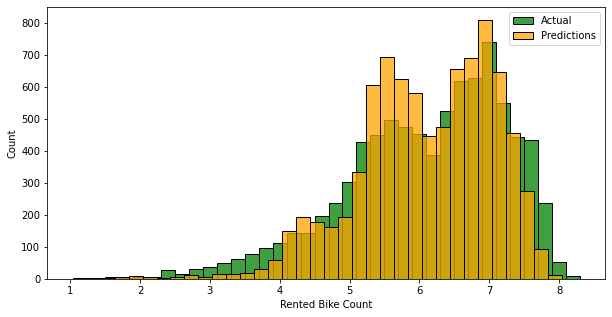

In [111]:
# As a final check, compare ranges of predictions to the actual values
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(y, label='Actual', color='green', binwidth=0.2)
sns.histplot(y_pred, label='Predictions', color='orange', binwidth=0.2)
plt.legend()
#Results below are pretty close, great :)

## Conclusion

Looking at the positive coefficient, I am able to identify the most important features in this model, which are:
- Temperature
- Humidity
- Visibility
- ALL of the categorical variables (Day of Week, Seasons, Shift)

## Next Steps

In order to get more accurate prediction model, I suggest:
- Gather more bike rental data especially post COVID-19 period, ideally throughout 2022
- Try to incorporate Random Forest Regression which might work well with the Bike Rental data. As Random Forest Regression is a prediction model based on the trees structure and it takes into account of many predictions and use the average value. These algorithms are more stable because any changes in dataset can impact one tree but not the forest of trees.

## Limitation

- Some datasets aren't suitable for Linear Regression 
- R-squared score of 0.707 is not perfect despite numerous models and transformation being tested 
- However, 0.707 is pretty good score especially in predicting human behaviour (Weather vs. No of bikes rented)
- In business/staffing modelling, 0.707 is adequate as it provides moderate linear relationship
